### 1 LambdaLR

In [1]:
import matplotlib.pyplot as plt
def plot(lr_historys, titles):
  plt.figure(figsize=(len(titles)*6,5))
  for i, lr_history in enumerate(lr_historys):
    plt.subplot(1,len(titles),i+1)
    plt.plot(range(len(lr_history)), lr_history)
    plt.title(titles[i])
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('learning rate')
  plt.show()

In [2]:
import torch
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

NUM_EPOCHS = 100
model = nn.Linear(2, 1)

def scheduler_lr(optimizer, scheduler):
  lr_history = []

  """optimizer的更新在scheduler更新的前面"""
  for epoch in range(NUM_EPOCHS):
      optimizer.step() # 更新参数
      lr_history.append(optimizer.param_groups[0]['lr'])
      scheduler.step() # 调整学习率
  return lr_history


"""设置优化器，初始化学习率"""
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 

"""设置lr策略"""
lr_lambda = lambda epoch:1.0 if epoch<10 else np.math.exp(0.1*(10-epoch))
scheduler = LambdaLR(optimizer=optimizer,lr_lambda=lr_lambda)
lr_history = scheduler_lr(optimizer, scheduler)

In [3]:
class CustomLambdaLR:
  def __init__(self,optimizer,lr_lambda,last_epoch=-1):
    self.optimizer = optimizer    
    self.last_epoch = last_epoch

    if not isinstance(lr_lambda, list) and not isinstance(lr_lambda, tuple):
      self.lr_lambdas = [lr_lambda] * len(optimizer.param_groups)
    else:
      self.lr_lambdas = list(lr_lambda) 

  def get_lr(self):
    lr = []
    for lmbda, base_lr in zip(self.lr_lambdas, self.base_lrs):
      lr.append(base_lr * lmbda(self.last_epoch))
    return lr
  
  def step(self):
    self.base_lrs = [group['initial_lr'] for group in optimizer.param_groups]      

    self.last_epoch += 1

    lrs = self.get_lr()
    for param, lr in zip(self.optimizer.param_groups, lrs):
        param['lr'] = lr
        

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomLambdaLR(optimizer2, lr_lambda, last_epoch=0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

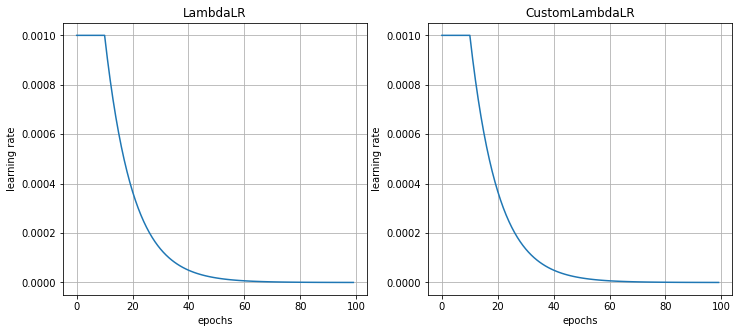

In [4]:
plot([lr_history,lr_history2], titles=['LambdaLR','CustomLambdaLR'])

### 2 MultiplicativeLR

In [5]:
from torch.optim.lr_scheduler import MultiplicativeLR
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
lmbda = lambda epoch: 0.95
scheduler = MultiplicativeLR(optimizer,lmbda)
lr_history = scheduler_lr(optimizer, scheduler)

In [6]:
class CustomMultiplicativeLR(CustomLambdaLR):
  def __init__(self,optimizer,lr_lambda,last_epoch=-1):    
    super(CustomMultiplicativeLR, self).__init__(optimizer,lr_lambda,last_epoch)

  def get_lr(self):
    if self.last_epoch > 0:
      return [group['lr'] * lmbda(self.last_epoch)
              for lmbda, group in zip(self.lr_lambdas, self.optimizer.param_groups)]
    else:
      return [group['lr'] for group in self.optimizer.param_groups]
  
  

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomMultiplicativeLR(optimizer2, lmbda, 0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

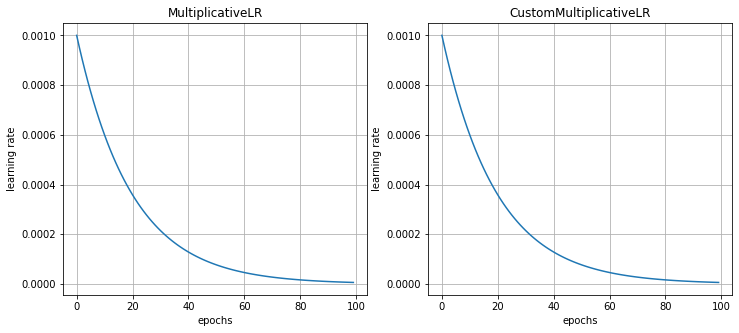

In [7]:
plot([lr_history,lr_history2], titles=['MultiplicativeLR','CustomMultiplicativeLR'])

### 3 StepLR

In [8]:
from torch.optim.lr_scheduler import StepLR
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer=optimizer, step_size=10, gamma=0.9)
lr_history = scheduler_lr(optimizer, scheduler)

In [9]:
class CustomStepLR:
  def __init__(self,optimizer,step_size,gamma=0.1,last_epoch=-1):
    self.optimizer = optimizer    
    self.last_epoch = last_epoch
    self.step_size = step_size
    self.gamma = gamma

  def get_lr(self):
    if (self.last_epoch == 0) or (self.last_epoch % self.step_size != 0):
      return [group['lr'] for group in self.optimizer.param_groups]
    
    return [group['lr'] * self.gamma
            for group in self.optimizer.param_groups]
  
  def step(self):    
    self.last_epoch += 1

    lrs = self.get_lr()
    for param, lr in zip(self.optimizer.param_groups, lrs):
        param['lr'] = lr

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomStepLR(optimizer2, step_size=10, gamma=0.9, last_epoch=0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

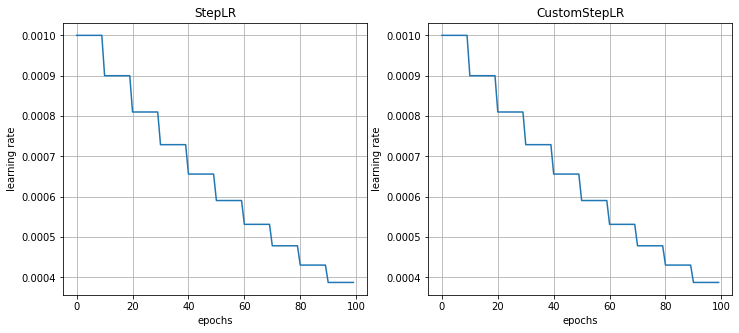

In [10]:
plot([lr_history,lr_history2], titles=['StepLR','CustomStepLR'])

### 4 MultiStepLR

In [11]:
from torch.optim.lr_scheduler import MultiStepLR
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = MultiStepLR(optimizer=optimizer, milestones=[50, 70, 90], gamma=0.2)
lr_history = scheduler_lr(optimizer, scheduler)

In [12]:
class CustomMultiStepLR(CustomStepLR):
  def __init__(self,optimizer,milestones,gamma=0.1,last_epoch=-1):        
    self.milestones = milestones
    super(CustomMultiStepLR,self).__init__(optimizer,step_size=0,gamma=gamma,last_epoch=last_epoch)

  def get_lr(self):
    if self.last_epoch not in self.milestones:
      return [group['lr'] for group in self.optimizer.param_groups]
    return [group['lr'] * self.gamma
            for group in self.optimizer.param_groups] 
 

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomMultiStepLR(optimizer2,milestones=[50, 70, 90],gamma=0.2,last_epoch=0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

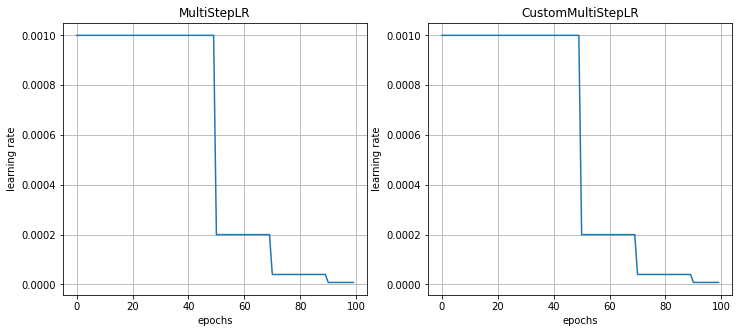

In [13]:
plot([lr_history,lr_history2], titles=['MultiStepLR','CustomMultiStepLR'])

### 5 ExponentialLR

In [14]:
from torch.optim.lr_scheduler import ExponentialLR
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer=optimizer, gamma=0.9)
lr_history = scheduler_lr(optimizer, scheduler)

In [15]:
class CustomExponentialLR(CustomStepLR):
  def __init__(self,optimizer,gamma=0.1,last_epoch=-1): 
    super(CustomExponentialLR,self).__init__(optimizer,step_size=0,gamma=gamma,last_epoch=last_epoch)

  def get_lr(self):
    if self.last_epoch == 0:
      return [group['lr'] for group in self.optimizer.param_groups]
    return [group['lr'] * self.gamma 
            for group in self.optimizer.param_groups]

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomExponentialLR(optimizer2,gamma=0.9,last_epoch=0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

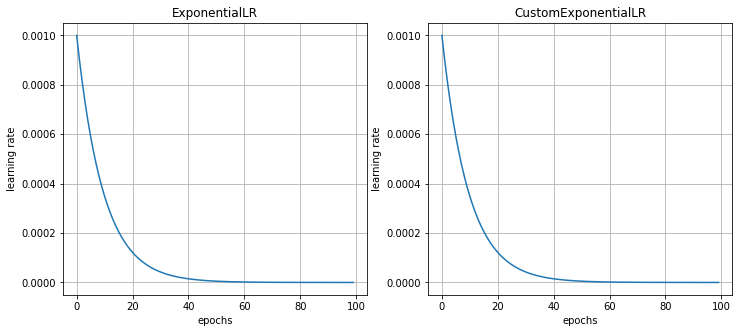

In [16]:
plot([lr_history,lr_history2], titles=['ExponentialLR','CustomExponentialLR'])

### 6 CosineAnnealingLR

In [17]:
from torch.optim.lr_scheduler import CosineAnnealingLR
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=10, eta_min=1e-6)
lr_history = scheduler_lr(optimizer, scheduler)

In [18]:
import math
class CustomCosineAnnealingLR:
  def __init__(self,optimizer,T_max,eta_min,last_epoch=-1):
    self.optimizer = optimizer    
    self.last_epoch = last_epoch
    self.T_max = T_max
    self.eta_min = eta_min

  def get_lr(self):
    if self.last_epoch == 0:
      return [group['lr'] for group in self.optimizer.param_groups]
    elif (self.last_epoch - 1 - self.T_max) % (2 * self.T_max) == 0:
      return [group['lr'] + (base_lr - self.eta_min) *
              (1 - math.cos(math.pi / self.T_max)) / 2
              for base_lr, group in
              zip(self.base_lrs, self.optimizer.param_groups)]
    return [(1 + math.cos(math.pi * self.last_epoch / self.T_max)) /
            (1 + math.cos(math.pi * (self.last_epoch - 1) / self.T_max)) *
            (group['lr'] - self.eta_min) + self.eta_min
            for group in self.optimizer.param_groups]
  
  def step(self):
    self.base_lrs = [group['initial_lr'] for group in optimizer.param_groups]  
    
    self.last_epoch += 1

    lrs = self.get_lr()
    for param, lr in zip(self.optimizer.param_groups, lrs):
        param['lr'] = lr

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomCosineAnnealingLR(optimizer=optimizer2, T_max=10, eta_min=1e-6,last_epoch=0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

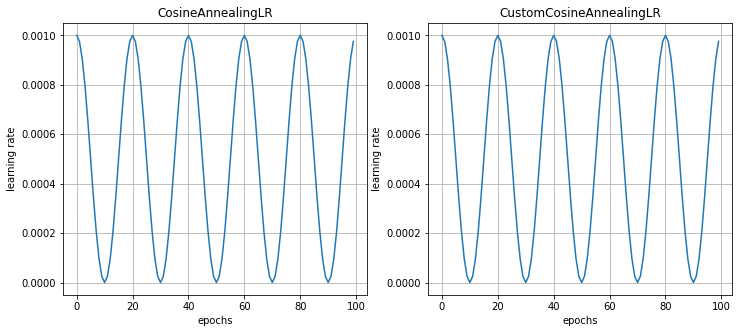

In [19]:
plot([lr_history,lr_history2], titles=['CosineAnnealingLR','CustomCosineAnnealingLR'])

### 7 warmup

In [20]:
class WarmupLR:
  def __init__(self, optimizer, num_warm) -> None:
    self.optimizer = optimizer
    self.num_warm = num_warm
    self.lr = [group['lr'] for group in self.optimizer.param_groups]
    self.num_step = 0
  
  def __compute(self, lr) -> float:
    return lr * min(self.num_step ** (-0.5), self.num_step * self.num_warm ** (-1.5))
  
  def step(self) -> None:
    self.num_step += 1
    lr = [self.__compute(lr) for lr in self.lr]
    for i, group in enumerate(self.optimizer.param_groups):
        group['lr'] = lr[i]

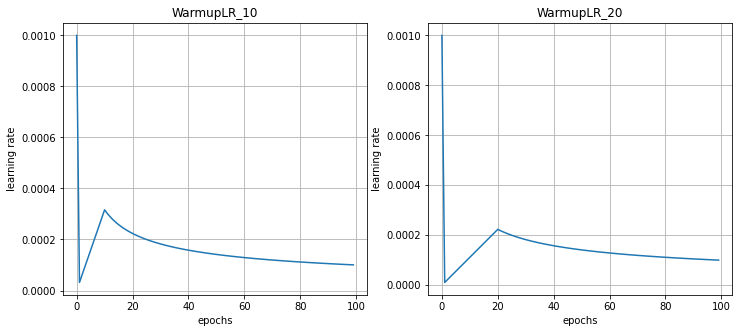

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = WarmupLR(optimizer=optimizer, num_warm=10)
lr_history = scheduler_lr(optimizer, scheduler)
optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = WarmupLR(optimizer=optimizer2, num_warm=20)
lr_history2 = scheduler_lr(optimizer2, scheduler2)
plot([lr_history,lr_history2], titles=['WarmupLR_10','WarmupLR_20'])

### 8 CosineAnnealingWarmRestarts

In [22]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, T_mult=2, eta_min=-1e-5)
lr_history = scheduler_lr(optimizer, scheduler)

In [23]:
class CustomCosineAnnealingWarmRestarts:
  def __init__(self,optimizer,T_0,T_mult=1,eta_min=0,last_epoch=-1):
    self.optimizer = optimizer    
    self.last_epoch = last_epoch
    self.T_0 = T_0
    self.T_i = T_0
    self.T_mult = T_mult
    self.eta_min = eta_min
    self.T_cur = last_epoch

  def get_lr(self):
    return [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.T_cur / self.T_i)) / 2
                for base_lr in self.base_lrs]
  
  def step(self):
    self.base_lrs = [group['initial_lr'] for group in optimizer.param_groups]  
    
    if self.last_epoch < 0:
      epoch = 0
    else:
      epoch = self.last_epoch + 1
      self.T_cur = self.T_cur + 1
      if self.T_cur >= self.T_i:
        self.T_cur = self.T_cur - self.T_i
        self.T_i = self.T_i * self.T_mult
      else:        
        if epoch >= self.T_0:
          if self.T_mult == 1:
            self.T_cur = epoch % self.T_0
          else:
            n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
            self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
            self.T_i = self.T_0 * self.T_mult ** (n)
        else:
          self.T_i = self.T_0
          self.T_cur = epoch
    
    self.last_epoch = math.floor(epoch)

    lrs = self.get_lr()
    for param, lr in zip(self.optimizer.param_groups, lrs):
        param['lr'] = lr

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomCosineAnnealingWarmRestarts(optimizer=optimizer2,T_0=10,T_mult=2,eta_min=-1e-5,last_epoch=0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

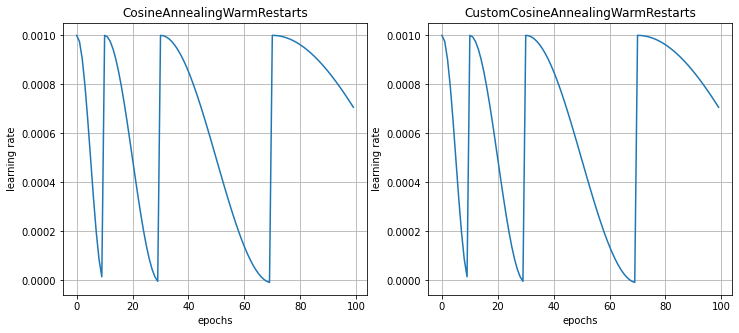

In [24]:
plot([lr_history,lr_history2], titles=['CosineAnnealingWarmRestarts','CustomCosineAnnealingWarmRestarts'])

### 9 ReduceLROnPlateau

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def scheduler_lr_reduce(optimizer, scheduler):
  lr_history = []

  """optimizer的更新在scheduler更新的前面"""
  for epoch in range(NUM_EPOCHS):
    optimizer.step() # 更新参数
    lr_history.append(optimizer.param_groups[0]['lr'])
    val_loss = 0.1
    scheduler.step(val_loss) # 调整学习率
  return lr_history

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.5, min_lr=-1e-7, patience=10)
lr_history = scheduler_lr_reduce(optimizer, scheduler)

In [26]:
from torch._six import inf
class CustomReduceLROnPlateau:
  def __init__(self,optimizer,mode='min', factor=0.1, patience=10,
          threshold=1e-4, threshold_mode='rel', cooldown=0,
          min_lr=0, eps=1e-8, verbose=False):
    
    self.optimizer = optimizer    
    self.factor = factor
    
    if not isinstance(min_lr, list) and not isinstance(min_lr, tuple):
      self.min_lrs = [min_lr] * len(optimizer.param_groups)
    else:
      self.min_lrs = list(min_lr)

    self.patience = patience
    self.cooldown = cooldown
    self.cooldown_counter = 0
    self.mode = mode
    self.threshold = threshold
    self.threshold_mode = threshold_mode
    self.best = None
    self.num_bad_epochs = None
    self.mode_worse = None  # the worse value for the chosen mode
    self.eps = eps
    self.verbose = verbose
    self.last_epoch = 0
    self._init_is_better(mode=mode, threshold=threshold,threshold_mode=threshold_mode)
    self._reset()

  def _reset(self):
      """Resets num_bad_epochs counter and cooldown counter."""
      self.best = self.mode_worse
      self.cooldown_counter = 0
      self.num_bad_epochs = 0
  
  def _init_is_better(self, mode, threshold, threshold_mode):
    if mode not in {'min', 'max'}:
      raise ValueError('mode ' + mode + ' is unknown!')
    if threshold_mode not in {'rel', 'abs'}:
      raise ValueError('threshold mode ' + threshold_mode + ' is unknown!')

    if mode == 'min':
      self.mode_worse = inf
    else:  # mode == 'max':
      self.mode_worse = -inf

    self.mode = mode
    self.threshold = threshold
    self.threshold_mode = threshold_mode
  
  @property
  def in_cooldown(self):
      return self.cooldown_counter > 0

  def is_better(self, a, best):
    if self.mode == 'min' and self.threshold_mode == 'rel':
      rel_epsilon = 1. - self.threshold
      return a < best * rel_epsilon

    elif self.mode == 'min' and self.threshold_mode == 'abs':
      return a < best - self.threshold

    elif self.mode == 'max' and self.threshold_mode == 'rel':
      rel_epsilon = self.threshold + 1.
      return a > best * rel_epsilon

    else:  # mode == 'max' and epsilon_mode == 'abs':
      return a > best + self.threshold

  def _reduce_lr(self, epoch):
    for i, param_group in enumerate(self.optimizer.param_groups):
      old_lr = float(param_group['lr'])
      new_lr = max(old_lr * self.factor, self.min_lrs[i])
      if old_lr - new_lr > self.eps:
        param_group['lr'] = new_lr
        if self.verbose:
          epoch_str = ("%.2f" if isinstance(epoch, float) else
                        "%.5d") % epoch
          print('Epoch {}: reducing learning rate'
                ' of group {} to {:.4e}.'.format(epoch_str, i, new_lr))
  def step(self, metrics):
    # convert `metrics` to float, in case it's a zero-dim Tensor
    current = float(metrics)    
    
    self.last_epoch += 1 

    if self.is_better(current, self.best):
      self.best = current
      self.num_bad_epochs = 0
    else:
      self.num_bad_epochs += 1

    if self.in_cooldown:
      self.cooldown_counter -= 1
      self.num_bad_epochs = 0  # ignore any bad epochs in cooldown

    if self.num_bad_epochs > self.patience:
      self._reduce_lr(self.last_epoch)
      self.cooldown_counter = self.cooldown
      self.num_bad_epochs = 0

    self._last_lr = [group['lr'] for group in self.optimizer.param_groups]              

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomReduceLROnPlateau(optimizer=optimizer2,mode='min',factor=0.5,min_lr=-1e-7,patience=10)
lr_history2 = scheduler_lr_reduce(optimizer2, scheduler2)

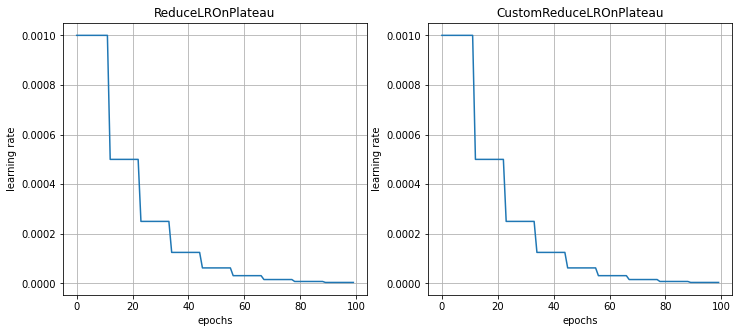

In [27]:
plot([lr_history,lr_history2], titles=['ReduceLROnPlateau','CustomReduceLROnPlateau'])

### 10 CyclicLR

In [28]:
from torch.optim.lr_scheduler import CyclicLR
lr_histories = []
titles = ['triangular','triangular2','exp_range']
for mode in titles:
  optimizer = torch.optim.SGD(model.parameters(), lr=0)
  scheduler = CyclicLR(optimizer=optimizer,base_lr=1e-5, max_lr=1e-1, step_size_up=10, mode=mode, gamma=0.9)
  lr_histories.append(scheduler_lr(optimizer, scheduler))

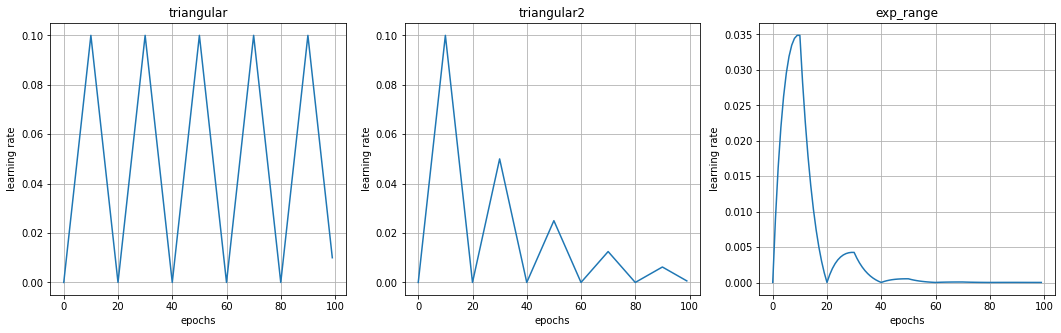

In [29]:
plot(lr_histories, titles)

### 11 OneCycleLR

In [30]:
from torch.optim.lr_scheduler import OneCycleLR
lr_histories = []
titles = ['cos','linear']
for mode in titles:
  optimizer = torch.optim.SGD(model.parameters(), lr=0)
  scheduler = OneCycleLR(optimizer=optimizer, max_lr=1e-1,epochs=10, steps_per_epoch=10,anneal_strategy=mode)
  lr_histories.append(scheduler_lr(optimizer, scheduler))

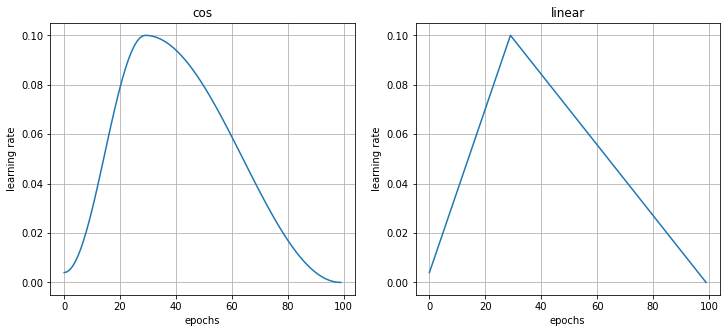

In [31]:
plot(lr_histories, titles)

### 12 ConstantLR

In [32]:
from torch.optim.lr_scheduler import ConstantLR
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
scheduler = ConstantLR(optimizer=optimizer,factor=1.0/3,total_iters=50)
lr_history = scheduler_lr(optimizer, scheduler)

In [33]:
class CustomConstantLR:
  def __init__(self,optimizer,factor,total_iters,last_epoch=-1):
    self.optimizer = optimizer    
    self.factor = factor
    self.total_iters = total_iters
    self.last_epoch = last_epoch

  def get_lr(self):
    if self.last_epoch == 0:
      return [group['lr'] * self.factor for group in self.optimizer.param_groups]

    if (self.last_epoch > self.total_iters or (self.last_epoch != self.total_iters)):
      return [group['lr'] for group in self.optimizer.param_groups]

    if (self.last_epoch == self.total_iters):
      return [group['lr'] * (1.0 / self.factor) for group in self.optimizer.param_groups]
  
  def step(self):    
    self.last_epoch += 1

    lrs = self.get_lr()
    for param, lr in zip(self.optimizer.param_groups, lrs):
        param['lr'] = lr

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomConstantLR(optimizer2,factor=1.0/3,total_iters=50,last_epoch=0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

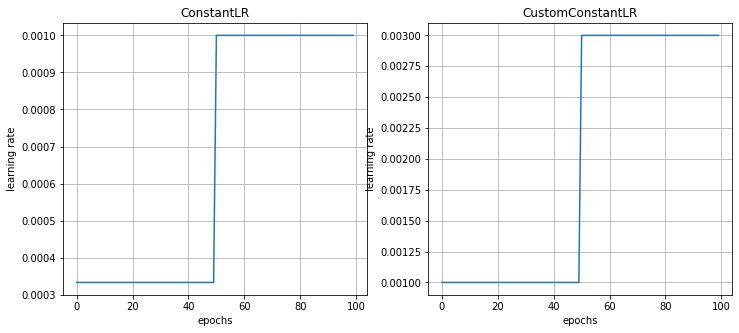

In [34]:
plot([lr_history,lr_history2], titles=['ConstantLR','CustomConstantLR'])

### 13 LinearLR

In [35]:
from torch.optim.lr_scheduler import LinearLR
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
scheduler = LinearLR(optimizer=optimizer,start_factor=1.0/3,end_factor=1.0,total_iters=15)
lr_history = scheduler_lr(optimizer, scheduler)

In [36]:
class CustomLinearLR:
  def __init__(self,optimizer,start_factor=1.0/3,end_factor=1.0,total_iters=5,last_epoch=-1):
    self.optimizer = optimizer    
    self.start_factor = start_factor
    self.end_factor = end_factor
    self.total_iters = total_iters
    self.last_epoch = last_epoch

  def get_lr(self):
    if self.last_epoch == 0:
      return [group['lr'] * self.start_factor for group in self.optimizer.param_groups]

    if (self.last_epoch > self.total_iters):
      return [group['lr'] for group in self.optimizer.param_groups]

    return [group['lr'] * (1. + (self.end_factor - self.start_factor) /
          (self.total_iters * self.start_factor + (self.last_epoch - 1) * (self.end_factor - self.start_factor)))
          for group in self.optimizer.param_groups]
  
  def step(self):    
    self.last_epoch += 1

    lrs = self.get_lr()
    for param, lr in zip(self.optimizer.param_groups, lrs):
        param['lr'] = lr

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler2 = CustomLinearLR(optimizer2,start_factor=1.0/3,end_factor=1.0,total_iters=15,last_epoch=0)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

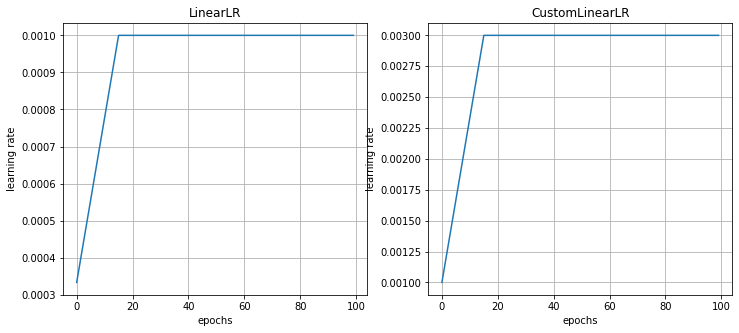

In [37]:
plot([lr_history,lr_history2], titles=['LinearLR','CustomLinearLR'])

### 14 ChainedScheduler

In [38]:
from torch.optim.lr_scheduler import ChainedScheduler
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
schedulers = [ConstantLR(optimizer,factor=0.1, total_iters=2),
        ExponentialLR(optimizer,gamma=0.9)]
scheduler = ChainedScheduler(schedulers)
lr_history = scheduler_lr(optimizer, scheduler)

In [39]:
class CustomChainedScheduler:
  def __init__(self,schedulers):
    self.schedulers = schedulers
    self.optimizer = schedulers[0].optimizer 
    self._last_lr = [group['lr'] for group in self.schedulers[-1].optimizer.param_groups]
  
  def step(self):    
    for scheduler in self.schedulers:
      scheduler.step()
    self._last_lr = [group['lr'] for group in self.schedulers[-1].optimizer.param_groups]

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
schedulers = [CustomConstantLR(optimizer2,factor=0.1,total_iters=2,last_epoch=0),
        CustomExponentialLR(optimizer2,gamma=0.9,last_epoch=0)]
scheduler2 = CustomChainedScheduler(schedulers)
lr_history2 = scheduler_lr(optimizer2, scheduler2)

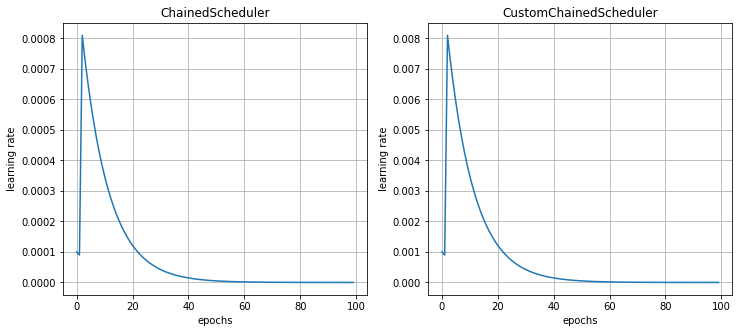

In [40]:
plot([lr_history,lr_history2], titles=['ChainedScheduler','CustomChainedScheduler'])

### 15 SequentialLR

In [41]:
from torch.optim.lr_scheduler import SequentialLR
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
schedulers = [ConstantLR(optimizer,factor=0.1,total_iters=2),
        ExponentialLR(optimizer,gamma=0.9)]
scheduler = SequentialLR(optimizer,schedulers,milestones=[2])
lr_history = scheduler_lr(optimizer,scheduler)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [42]:
from bisect import bisect_right

class CustomSequentialLR:
  def __init__(self,optimizer, schedulers, milestones, last_epoch=-1):
    self.schedulers = schedulers
    self.milestones = milestones
    self.last_epoch = last_epoch + 1
    self.optimizer = optimizer
  
  def step(self):
    self.last_epoch += 1
    idx = bisect_right(self.milestones, self.last_epoch)
    if idx > 0 and self.milestones[idx - 1] == self.last_epoch:
        self.schedulers[idx].step(0)
    else:
        self.schedulers[idx].step()

optimizer2 = torch.optim.SGD(model.parameters(), lr=1e-3)
schedulers = [ConstantLR(optimizer2,factor=0.1,total_iters=2),
        ExponentialLR(optimizer2,gamma=0.9)]
scheduler2 = CustomSequentialLR(optimizer2,schedulers,milestones=[2])
lr_history2 = scheduler_lr(optimizer2, scheduler2)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


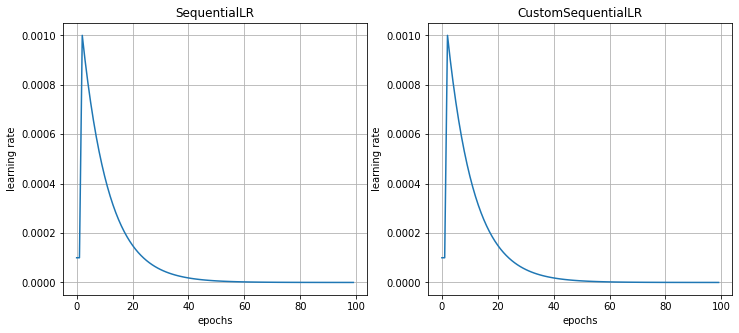

In [43]:
plot([lr_history,lr_history2], titles=['SequentialLR','CustomSequentialLR'])